In [2]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs, feature as cfeature
import os
from os import listdir
from os.path import isfile, join
import pandas as pd
import re
import xarray as xr
from matplotlib.colors import to_hex
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point
import contextily as cx
import geodatasets
import rasterio
from rasterio.transform import from_origin
from scripts.geodata import *
import matplotlib.colors as mcolors

#  Suppress warnings issued by Cartopy when downloading data files
warnings.filterwarnings('ignore')

# reload modules
%load_ext autoreload
%autoreload 2


## Transform to rasters for QGIS:

### Step 1: Open the NetCDF file


In [3]:
glacierName = 'rhone'
year = 2022

ds_xy_w = xr.open_dataset(f"results/nc/{glacierName}_{year}_w_lv95.nc")
ds_latlon_w = xr.open_dataset(f"results/nc/{glacierName}_{year}_w.nc")

ds_xy = xr.open_dataset(f"results/nc/{glacierName}_{year}_lv95.nc")
ds_latlon = xr.open_dataset(f"results/nc/{glacierName}_{year}.nc")

# Smooth the dataset
ds_xy_g = GaussianFilter(ds_xy)
ds_latlon_g = GaussianFilter(ds_latlon)
ds_xy_w_g = GaussianFilter(ds_xy_w)
ds_latlon_w_g = GaussianFilter(ds_latlon_w)

In [4]:
vmin, vmax = np.min([
    ds_xy.pred_masked.min().values,
    ds_xy_g.pred_masked.min()
]), np.max([ds_xy.pred_masked.max().values,
            ds_xy_g.pred_masked.max()])
max_abs_value = max(abs(vmin), abs(vmax))
norm = mcolors.TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)
vmin, vmax

(-8.38271713256836, 0.24431991577148438)

-8.38271713256836 0.24431991577148438
-7.828142453020673 0.04313045297672233


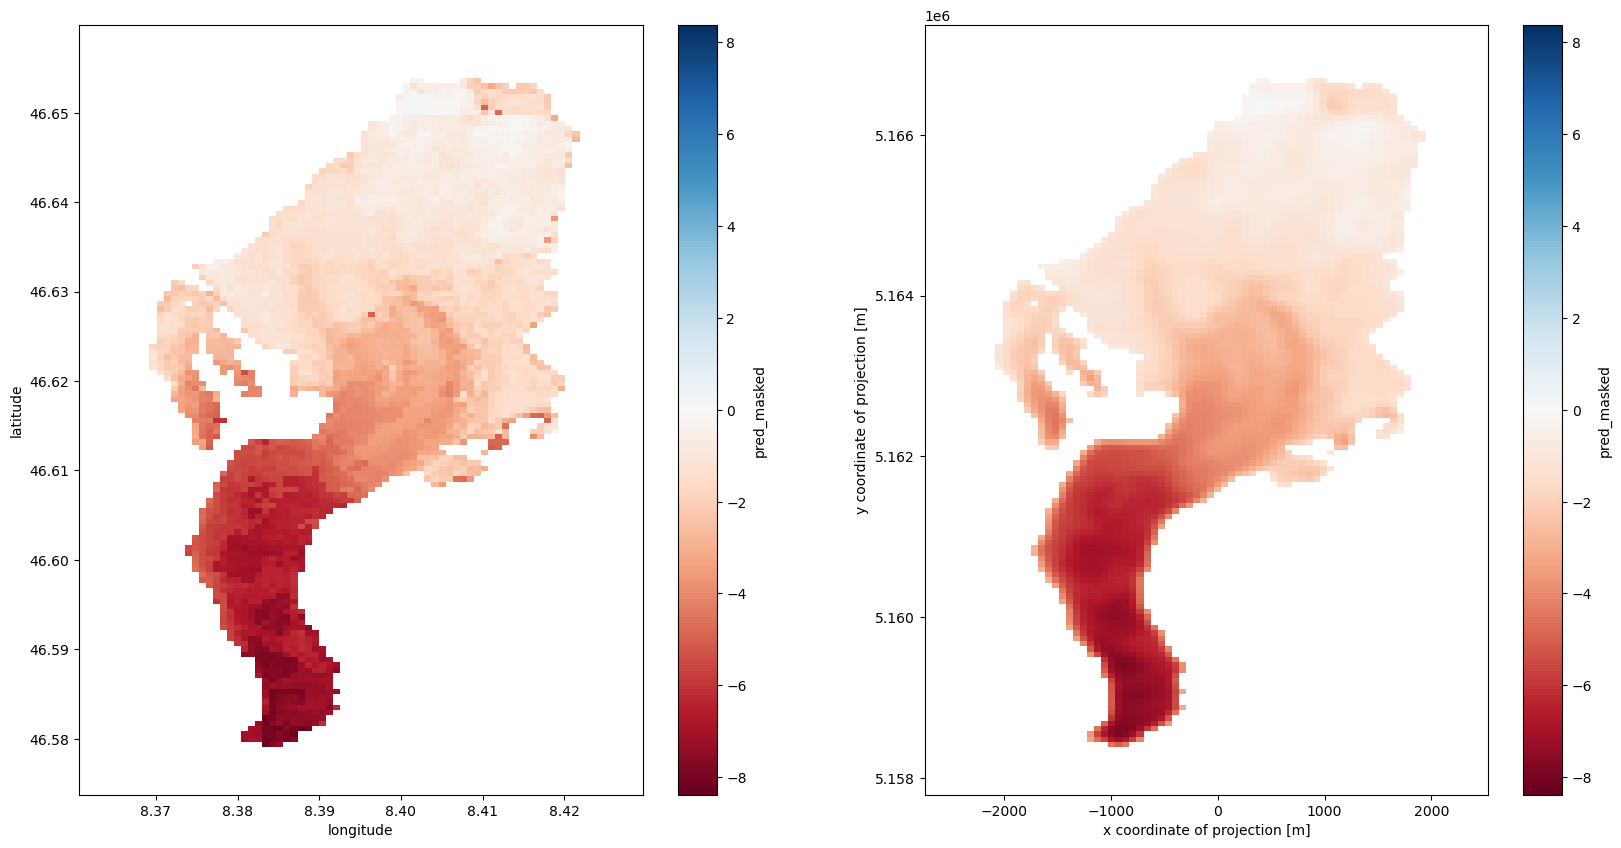

In [6]:
vmin, vmax = np.min(
    [ds_xy.pred_masked.min().values,
     ds_xy_g.pred_masked.min()]), np.max(
         [ds_xy.pred_masked.max().values,
          ds_xy_g.pred_masked.max()])
max_abs_value = max(abs(vmin), abs(vmax))
norm = mcolors.TwoSlopeNorm(vmin=-max_abs_value, vcenter=0, vmax=max_abs_value)

fig, axs = plt.subplots(1, 2, figsize=(20, 10))
ds_latlon.pred_masked.plot.imshow(cmap='RdBu', norm=norm, ax=axs[0])

# Plot or analyze `smoothed_data` as needed
ds_xy_g.pred_masked.plot.imshow(cmap='RdBu', norm=norm, ax=axs[1])

# print min and max values
print(ds_xy.pred_masked.min().values, ds_xy.pred_masked.max().values)
print(ds_xy_g.pred_masked.min().values,
      ds_xy_g.pred_masked.max().values)

### Step 2: transform to geopandas

In [7]:
gdf, lon, lat = toGeoPandas(ds_latlon_g)
gdf_w, lon_w, lat_w = toGeoPandas(ds_latlon_w_g)

# Reproject to LV95 (EPSG:2056) swiss coordinates
gdf_lv95 = gdf.to_crs("EPSG:2056")
gdf_lv95_w = gdf_w.to_crs("EPSG:2056")

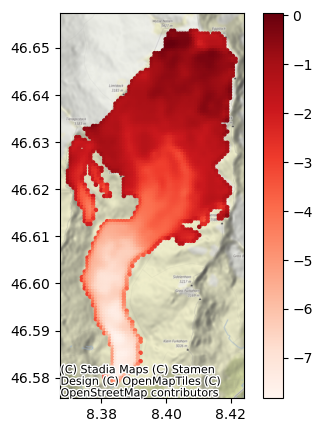

In [8]:
API_KEY = "000378bd-b0f0-46e2-a46d-f2165b0c6c02"
provider = cx.providers.Stadia.StamenTerrain(api_key=API_KEY)
provider["url"] = provider["url"] + f"?api_key={API_KEY}"

fig, ax = plt.subplots(figsize=(5, 5))
gdf_clean = gdf.dropna(subset=["data"])
gdf_clean.plot(
    column="data",  # Column to visualize
    cmap="Reds",  # Color map suitable for glacier data
    legend=True,  # Display a legend
    ax=ax,
    markersize=5,  # Adjust size if points are too small or large
    missing_kwds={"color": "lightgrey"}  # Define color for NaN values
)
cx.add_basemap(ax, crs=gdf.crs, source=provider)

### Step 3: transform to raster

In [9]:
# Transform to raster from geopandas
raster_data, extent = toRaster(
    gdf_w, lon_w, lat_w, file_name=f"results/tif/{glacierName}_{year}_w.tif")

raster_data_w, extent_w = toRaster(
    gdf, lon, lat, file_name=f"results/tif/{glacierName}_{year}.tif")

# reproject raster to Swiss coordinates (LV95)
reproject_raster_to_lv95(f"results/tif/{glacierName}_{year}_w.tif",
                         f"results/tif/{glacierName}_{year}_w_lv95.tif")

reproject_raster_to_lv95(f"results/tif/{glacierName}_{year}.tif",
                         f"results/tif/{glacierName}_{year}_lv95.tif")

In [13]:
# src_crs = 'EPSG:4326'

# fig, axs = plt.subplots(1, 2, figsize=(10, 8))
# vmin, vmax = np.nanmin(raster_data), np.nanmax(raster_data)  # Min value, ignoring NaNs

# ax = axs[0]
# img = ax.imshow(
#     raster_data,
#     extent=extent,
#     cmap='Reds_r',
#     vmin=vmin,
#     vmax=vmax,
#     alpha=1,
# )
# ax.set_xlabel('Longitude')
# ax.set_ylabel('Latitude')

# # open the reprojected raster
# with rasterio.open(f"results/tif/{glacierName}_{year}_lv95.tif") as src:
#     raster_data = src.read(1)  # Read the first band
#     extent = [
#         src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top
#     ]

# # Plot the raster
# ax = axs[1]
# ax.imshow(raster_data,
#           extent=extent,
#           cmap='Reds_r',
#           vmin=np.nanmin(raster_data),
#           vmax=np.nanmax(raster_data),
#           alpha=0.8)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')

### Opt step 4: for clariden
Need to merge two rasters

In [ ]:
if 'clariden' in glacierName: 
    merge_rasters('results/tif/claridenL_2022_w_lv95.tif',
              'results/tif/claridenU_2022_w_lv95.tif',
              'results/tif/clariden_2022_w_lv95.tif')